In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm 
import sys
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingCardDataset(
    data_dir = '/Users/marco/Desktop/PyTorch/Card_Classification/dataset_cards/train'
)

Create a Dictionary to map Classes to Label Names

In [4]:
data_dir = '/Users/marco/Desktop/PyTorch/Card_Classification/dataset_cards/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [5]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

In [6]:
dataset = PlayingCardDataset(data_dir, transform)

In [7]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

Loading the Create Dataset

In [26]:
dataloader = DataLoader(dataset, batch_size=32, shuffle = True)

PyTorch Model Building

In [18]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        #make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

Training the Model

In [16]:

training_dir = '/Users/marco/Desktop/PyTorch/Card_Classification/dataset_cards/train'
validation_dir = '/Users/marco/Desktop/PyTorch/Card_Classification/dataset_cards/valid'
test_dir = '/Users/marco/Desktop/PyTorch/Card_Classification/dataset_cards/test'

train_dataset = PlayingCardDataset(training_dir,transform=transform)
valid_dataset = PlayingCardDataset(validation_dir,transform=transform)
test_dataset = PlayingCardDataset(test_dir,transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [19]:
num_epochs = 5
train_losses, valid_losses = [], []


model = SimpleCardClassifier(num_classes=53)   
model.to(device) 

#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    training_loss = running_loss/ len(train_loader.dataset)
    train_losses.append(training_loss)
    
    #Validation
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)   
            outputs = model(images)
            loss = criterion(outputs, labels)   
            running_loss += loss.item() * images.size(0)
    valid_loss = running_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    

    #Print Stats
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_losses}, Validation Loss:{valid_losses}")
    
    

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: [1.5489626293542629], Validation Loss:[0.38493921036990186]


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Training Loss: [1.5489626293542629, 0.5647722253456696], Validation Loss:[0.38493921036990186, 0.23559500338896266]


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Training Loss: [1.5489626293542629, 0.5647722253456696, 0.35329478292687866], Validation Loss:[0.38493921036990186, 0.23559500338896266, 0.18605305563728763]


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Training Loss: [1.5489626293542629, 0.5647722253456696, 0.35329478292687866, 0.26136949382417474], Validation Loss:[0.38493921036990186, 0.23559500338896266, 0.18605305563728763, 0.17437874528596986]


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Training Loss: [1.5489626293542629, 0.5647722253456696, 0.35329478292687866, 0.26136949382417474, 0.17456648829476154], Validation Loss:[0.38493921036990186, 0.23559500338896266, 0.18605305563728763, 0.17437874528596986, 0.14056307639715807]


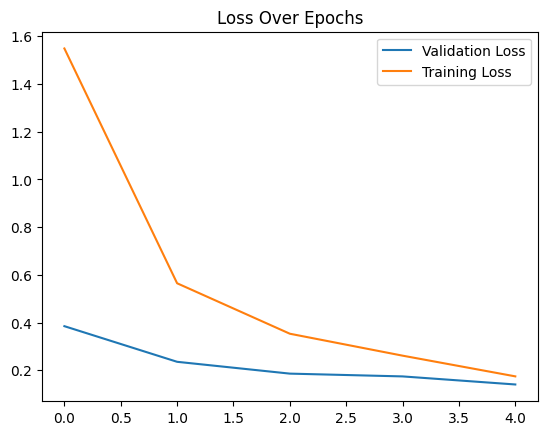

In [20]:
plt.plot(valid_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.title("Loss Over Epochs")
plt.legend()